In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from scipy.special import expit

from tqdm import  tqdm_notebook as tqdm

import scipy.signal as signal

from PIL import ImageFilter
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline  

from skimage import morphology

from skimage import filters

from skimage.feature import corner_peaks
from skimage.feature import corner_shi_tomasi
from skimage.feature import corner_harris

import time

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [3]:
# Функция принимающая на вход путь к файл. 
# Загружает картинку и превращает ее в серую.

def load_image(filename):
    return Image.open(filename).convert('L')

# Функция для бинаризации.
def trashhold(img, alpha = None):
    if alpha is None:
        return Image.fromarray(np.array(img))
    img_array = np.array(img)
    return Image.fromarray(np.array((img_array > alpha)*255, dtype = np.uint8))

# Функция, которая делает нигатив изображения.
def negative(img):
    img_array = np.array(img, dtype = np.int64)
    new_array = 255 - img_array
    return Image.fromarray(np.array(new_array, dtype = np.uint8))

# Функция, которая делит изображения на связные области и нумерует их.
def paint_objects(arr_input, MAX_key):

    arr = np.array(arr_input)
    
    key = MAX_key
    for i in tqdm(range(arr.shape[0])):
        for j in range(arr.shape[1]):
            if arr[i,j] == 1:
                list_x = [j]
                list_y = [i]
                while(len(list_x)):
                    x = list_x[-1]
                    y = list_y[-1]
                    flag = 0
                    arr[y][x] = key
                    if flag == 0:
                        if x+1 < arr.shape[1]:
                            if arr[y][x+1] == 1:
                                list_x.append(x+1)
                                list_y.append(y)
                                flag = 1
                    if flag == 0:
                        if x-1 > -1:
                            if arr[y][x-1] == 1:
                                list_x.append(x-1)
                                list_y.append(y)
                                flag = 1
                    if flag == 0:
                        if y+1 < arr.shape[0]:
                            if arr[y+1][x] == 1:
                                list_x.append(x)
                                list_y.append(y+1)
                                flag = 1
                    if flag == 0:
                        if x-1 > -1:
                            if arr[y-1][x] == 1:
                                list_x.append(x)
                                list_y.append(y-1)
                                flag = 1
                    if flag == 0:
                        list_y.pop()
                        list_x.pop()
                        flag = 1
                key += 1
                
    return arr, key

# Функция, которая по заданому номеру области, возращает картинку, только с этой областью.
def return_object(arr, key):
    array = np.zeros_like(arr)
    ind = np.where(arr == key)
    array[ind] += 255
    
    return Image.fromarray(array.astype(np.uint8))

# Функция, которая возвращает список площадей всех областей.
def object_size(arr, min_key, max_key):
    size = np.zeros(max_key-min_key+1)
    
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i,j] > 0:
                size[int(arr[i,j] - min_key)] += 1
    return np.array(size)

# Функция, которая находит все точки внтутри границы.
def find_internal_point(img):
    arr = (np.array(img)).astype(np.float64)
    
    new_array = np.zeros_like(arr)
    new_array_mask = np.zeros_like(arr)
    
    ind = np.where(arr != 0)
    begin_x = np.min(ind[1])
    end_x = np.max(ind[1])

    begin_y = np.min(ind[0])
    end_y = np.max(ind[0])
    
    for j in range(begin_y, end_y):
        for i in range(begin_x, end_x):
            if arr[j, i ] == 0:
                flag = np.zeros(4)

                ind_x = np.where(arr[j] > 0)[0]
                ind_y = np.where(arr[:, i] > 0)[0]

                if (ind_y > j).any():
                    flag[0] = 1
                if (ind_y < j).any():
                    flag[1] = 1

                if (ind_x < i).any():
                    flag[2] = 1

                if (ind_x > i).any():
                    flag[3] = 1

                if flag.all():
                    new_array[j, i] = 255
                    
    new_array = morphology.erosion(new_array/255.0, selem = morphology.disk(1))*255.0
    new_array = morphology.erosion(new_array/255.0, selem = morphology.disk(1))*255.0
            
    return new_array

# Функция, которая закрашивает все внутри границы.
def close_object(img):
    img_c = negative(img)
    internal_points = find_internal_point(img)
    
    img_1 = Image.fromarray(internal_points.astype(np.uint8))
    
    arr = (np.array(img_1)).astype(np.float64)
    arr_c = (np.array(img_c)).astype(np.float64)

    arr_new = morphology.dilation(arr/255.0, selem = morphology.disk(1))*255.0
    arr_new = (arr_new/255.0)*(arr_c/255.0)*255

    while(np.sum(arr_new - arr) != 0):
        arr = np.array(arr_new)
        arr_new = morphology.dilation(arr/255.0, selem = morphology.disk(1))*255.0
        arr_new = (arr_new/255.0)*(arr_c/255.0)*255
        
        if np.sum(arr_new/255.0) > 6000:
            new_image = Image.fromarray((arr_new + + np.array(img, dtype = np.float64)).astype(np.uint8))
            return new_image


    new_image = Image.fromarray((arr + np.array(img, dtype = np.float64)).astype(np.uint8))
    
    arr = np.array(new_image, dtype = np.float64)
    arr = morphology.dilation(arr/255.0, selem = morphology.disk(1))*255.0
    arr = morphology.dilation(arr/255.0, selem = morphology.disk(1))*255.0
    
    arr = morphology.erosion(arr/255.0, selem = morphology.disk(1))*255.0
    arr = morphology.erosion(arr/255.0, selem = morphology.disk(1))*255.0
    arr = morphology.erosion(arr/255.0, selem = morphology.disk(1))*255.0
    
    new_image = Image.fromarray(arr.astype(np.uint8))
    
    return new_image

# Функция, которая по заданой фигуре возвращает фигуру с закрашеной внутреностью.
def get_object_images(img):
    arr = (np.array(img)).astype(np.float64)
    gaus = (filters.sobel(arr/255.0)*255).astype(np.float64)

    new = 4*(gaus)

    new[np.where(new < 0)] = 0
    new[np.where(new > 255)] = 255

    img_1 = Image.fromarray(new.astype(np.uint8))
    
    arr = (np.array(img_1)).astype(np.float64)
    gaus = (filters.gaussian(arr/255.0, sigma=0.3)*255).astype(np.float64)

    new = 4*(gaus)

    new[np.where(new < 0)] = 0
    new[np.where(new > 255)] = 255

    img_2 = Image.fromarray(new.astype(np.uint8))
    
    img_3 = trashhold(img_2, 120)
    
    MAX_key = 1000
    ARR, key = paint_objects(np.array(img_3)/255, MAX_key)
    
    size_of_object = object_size(ARR, MAX_key, key)
    
    ind = np.where((size_of_object > 100) * (size_of_object < 6000))[0]
    
    List_of_object = []
    List_of_object_not_closed = []
    for i in tqdm(range(ind.shape[0])):
        new_image = return_object(ARR, MAX_key+ind[i])
        List_of_object_not_closed.append(new_image)
        new_image_close = close_object(new_image)
        a = np.array(new_image_close)
        if np.where(a > 0)[0].shape[0] < 5400 and np.where(a > 0)[0].shape[0] > 1100:
            List_of_object.append(new_image_close)
    
    return img_1, img_2, img_3, ARR, ind, List_of_object, List_of_object_not_closed

# Функция, которая для каждого обьекта возвращает количество углов на изображению.
def get_corners(List_of_objects):
    List_of_number_of_corners = []
    List_of_coords = []
    
    for obj in tqdm(List_of_objects):
        pict = obj
        arr = (np.array(pict)).astype(np.float64)
        gaus = (filters.gaussian(arr/255.0, sigma=2)*255).astype(np.float64)

        new = (gaus)

        new[np.where(new < 0)] = 0
        new[np.where(new > 255)] = 255

        coords = corner_peaks(corner_harris(new, sigma = 5), min_distance=5)
    
        if np.size(coords) != 0:
            List_of_number_of_corners.append(coords.shape[0])
            List_of_coords.append(coords[0])
        else:
            List_of_number_of_corners.append(0)
            List_of_coords.append(np.where(image == 255)[0][0])
        
    return List_of_number_of_corners, List_of_coords

# Функция, которая для каждого обьекта возвращает является ли он выпуклым.
def get_convex(List_of_objects):
    List_of_convex = []
    
    for obj in tqdm(List_of_objects):
        arr = (np.array(obj)).astype(np.float64)
        new = morphology.convex_hull_image(arr/255.0)*255.0

        chul_im = Image.fromarray(new.astype(np.uint8))
        
        arr1 = np.array(chul_im, dtype = np.float64)
        arr2 = np.array(obj, dtype = np.float64)

        arr_new = arr1 - arr2

        arr_new = morphology.erosion(arr_new/255.0, selem = morphology.disk(1))

        List_of_convex.append(np.sum(arr_new) < 10)
        
    return List_of_convex

# Функция, которая возвращает кординаты всех углов.
def get_all_corners(picture):
    arr = (np.array(picture)).astype(np.float64)
    gaus = (filters.gaussian(arr/255.0, sigma=2)*255).astype(np.float64)
    new = (gaus)

    new[np.where(new < 0)] = 0
    new[np.where(new > 255)] = 255
    
    coords = corner_peaks(corner_harris(new, sigma = 5), min_distance=5)
    
    return coords

In [4]:
def all_experiment(img):
    print("Ищем связные области и находим нужные нам фигуры на картах:")
    img_1, img_2, img_3, ARR, indexes, List_of_object, List_of_object_not_closed = get_object_images(img)

    arr = np.zeros_like(np.array(List_of_object[0]), dtype= np.float64)

    for ob in List_of_object:
        arr += np.array(ob, dtype = np.float64)

    img_new = Image.fromarray(arr.astype(np.uint8))
    
    print("Ищем углы для каждой области:")
    List_of_corners, List_of_coords = get_corners(List_of_object)
    
    print("Проверяем выпуклость:")
    List_of_convex = get_convex(List_of_object)
    
    coords = get_all_corners(img_new)
    
    plt.imshow(img)
    for i in range(len(List_of_corners)):
        s = ''
        if List_of_convex[i]:
            s = 'C'
        if List_of_corners[i] > 2:
            plt.annotate('P' + str(List_of_corners[i]) + s, (0,0), xytext=(List_of_coords[i][1], List_of_coords[i][0] + 15), fontsize=15, color = 'r')
        else:
            plt.annotate('N' + s, (0,0), xytext=(List_of_coords[i][1], List_of_coords[i][0] + 15), fontsize=15, color = 'r')

    plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=6)
    plt.savefig('./answers/IMG_10.pdf')
    plt.show()
    
    return len(List_of_object)

In [5]:
img = load_image('samples/IMG_10.jpg')

Ищем связные области и находим нужные нам фигуры на картах:



Ищем углы для каждой области:



Проверяем выпуклость:


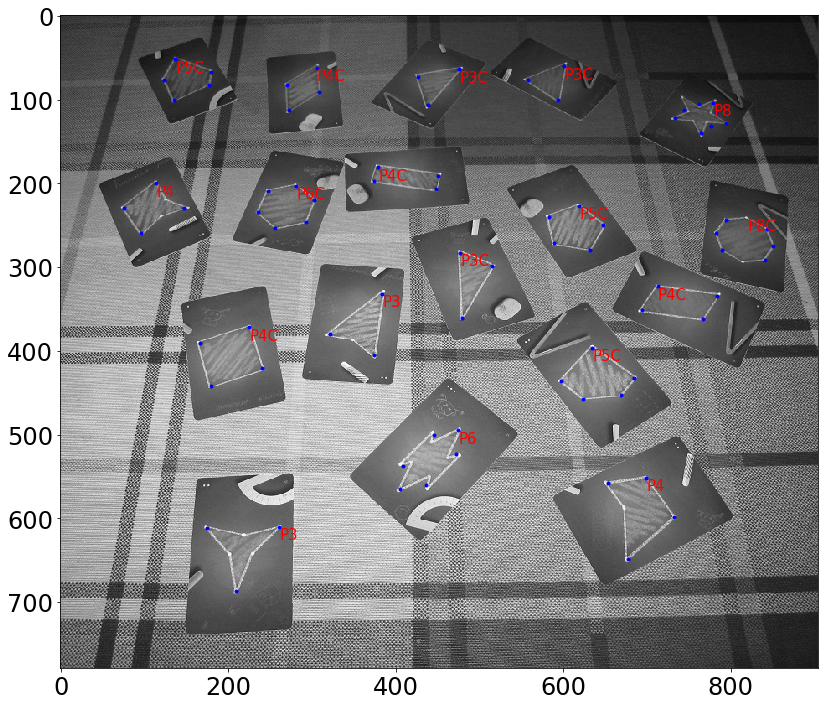

18

In [6]:
all_experiment(img)